# 학습 데이터 준비 및 전처리 전체 과정

1. **S3 또는 로컬에서 QA JSONL 데이터 다운로드**  
    - S3 버킷에서 AWS CLI 또는 boto3를 사용해 `qa_pairs.jsonl` 파일을 다운로드하거나, 이미 로컬에 파일이 있다면 해당 경로를 지정해 사용합니다.

2. **QA 쌍 로드**  
    - `data/qa_pairs.jsonl` 파일을 한 줄씩 읽어 각 줄을 JSON 객체로 파싱하여 `qa_pairs` 리스트에 저장합니다.
    - 전체 QA 쌍의 개수와 첫 번째 QA 쌍의 내용을 출력해 데이터가 정상적으로 로드되었는지 확인합니다.

3. **데이터 품질 검증 및 전처리**  
    - 빈 질문/답변, 너무 짧거나 긴 답변을 필터링합니다.
    - 여러 공백 제거, 앞뒤 공백 제거 등 텍스트 정제를 수행합니다.
    - 전처리된 결과는 `filtered_qa_pairs`에 저장합니다.

4. **중복 질문 확인 및 제거**  
    - 동일한 질문이 여러 번 등장할 경우, 첫 번째로 발견된 QA 쌍만 유지하여 데이터셋의 다양성을 확보합니다.

5. **질문/답변 길이 분석 및 시각화**  
    - 질문(`q_lengths`), 답변(`a_lengths`)의 길이 분포를 분석하고, 히스토그램 등으로 시각화합니다.

6. **QA 쌍 추가**  
    - 디버깅 및 테스트를 위해 두 개의 QA 쌍(`qa_add`)을 직접 리스트에 추가하고, `qa_pairs`에 확장합니다.

7. **데이터 확인**  
    - 전체 QA 쌍의 개수를 다시 출력하고, 마지막 두 개의 QA 쌍을 출력해 추가된 데이터가 반영되었는지 확인합니다.

8. **파인튜닝용 데이터 변환 및 저장**  
    - 각 QA 쌍을 LLM 파인튜닝에 적합한 instruction 기반 포맷(`instruction`, `input`, `output` 필드)으로 변환합니다.
    - 변환된 데이터를 `data/train_data.jsonl` 파일에 한 줄씩 저장하며, 한글이 깨지지 않도록 `ensure_ascii=False` 옵션을 사용합니다.
    - 파일이 정상적으로 생성되었는지 확인합니다.

### S3 저장소 또는 로컬에서 QA JSONL 데이터 다운로드

- S3 버킷 또는 로컬 파일 시스템에서 `qa_pairs.jsonl` 파일을 다운로드하는 방법을 안내합니다.
- AWS CLI를 사용하여 S3에서 파일을 다운로드하거나, 이미 로컬에 파일이 있는 경우 해당 경로를 지정하여 사용할 수 있습니다.
- 예시:
    - S3에서 다운로드:  
        ```bash
        aws s3 cp s3://<bucket-name>/path/to/qa_pairs.jsonl data/qa_pairs.jsonl
        ```
    - 로컬 파일 사용:  
        - `data/qa_pairs.jsonl` 경로에 파일이 존재하는지 확인 후 사용합니다.

In [ ]:
import boto3

#출력 데이터 S3 경로
s3_client = boto3.client('s3')
bucket = "sagemaker-us-east-1-740128158828"
key = "pdf-qa-generation/output/2025-05-28-15-37-22/qa_pairs.jsonl"
local_path = "data/qa_pairs.jsonl"

s3_client.download_file(bucket, key, local_path)
print("결과 다운로드 완료: qa_pairs.jsonl")

## 데이터 품질 검증 및 전처리

이 단계에서는 다음과 같은 작업을 수행합니다:
1. 빈 질문이나 답변 제외
2. 너무 짧거나 너무 긴 답변 필터링
3. 텍스트 정제 (여러 공백 제거, 앞뒤 공백 제거)
4. 중복 질문 확인 및 제거

In [5]:
import json

# 파일 경로
file_path = "data/qa_pairs.jsonl"

# 파일 읽기
qa_pairs = []
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        # 각 줄을 JSON으로 파싱
        qa_pair = json.loads(line.strip())
        qa_pairs.append(qa_pair)

# 데이터 확인
print(f"총 {len(qa_pairs)}개의 QA 쌍을 로드했습니다.")
print("첫 번째 QA 쌍:", qa_pairs[0])

총 15개의 QA 쌍을 로드했습니다.
첫 번째 QA 쌍: {'QUESTION': '외환 수급 불균형 구조가 형성된 주요 원인은 무엇입니까?', 'ANSWER': '외화 유입 대비 유출 우위가 지속되어 외환 수급 불균형 구조가 형성되었습니다.'}


In [6]:
# QA 데이터 품질 검증 및 필터링
filtered_qa_pairs = []
invalid_count = 0

for qa in qa_pairs:
    # 빈 질문이나 답변 제외
    if not qa["QUESTION"].strip() or not qa["ANSWER"].strip():
        invalid_count += 1
        continue
        
    # 너무 짧은 답변(10자 미만) 제외 - 가치 있는 정보가 적을 가능성 높음
    if len(qa["ANSWER"]) < 10:
        invalid_count += 1
        continue
    
    # 너무 긴 답변(2000자 초과) 제외 - 컨텍스트 길이 제한 고려
    if len(qa["ANSWER"]) > 2000:
        invalid_count += 1
        continue
    
    # 기본 텍스트 정제 (여러 공백 제거, 앞뒤 공백 제거)
    qa_cleaned = {
        "QUESTION": " ".join(qa["QUESTION"].split()),
        "ANSWER": " ".join(qa["ANSWER"].split())
    }
    
    filtered_qa_pairs.append(qa_cleaned)

print(f"총 {len(qa_pairs)}개 QA 쌍 중 {invalid_count}개가 필터링되어 {len(filtered_qa_pairs)}개가 남았습니다.")

총 15개 QA 쌍 중 0개가 필터링되어 15개가 남았습니다.


## 중복 질문 확인 및 처리

동일한 질문이 여러 번 등장할 경우, 첫 번째로 발견된 QA 쌍만 유지합니다.
이는 데이터셋의 다양성을 확보하고 특정 유형의 질문에 편향되는 것을 방지합니다.

In [7]:
from collections import Counter

# 중복 질문 확인
question_counter = Counter([qa["QUESTION"] for qa in filtered_qa_pairs])
duplicates = {q: count for q, count in question_counter.items() if count > 1}

if duplicates:
    print(f"{len(duplicates)}개의 중복된 질문이 발견되었습니다.")
    print("중복 질문 샘플 (최대 5개):")
    for q, count in list(duplicates.items())[:5]:
        print(f"'{q}' - {count}회 등장")
        
    # 중복 처리 (첫 번째 발견된 QA 쌍만 유지)
    unique_qa_pairs = []
    seen_questions = set()
    
    for qa in filtered_qa_pairs:
        if qa["QUESTION"] not in seen_questions:
            unique_qa_pairs.append(qa)
            seen_questions.add(qa["QUESTION"])
    
    print(f"중복 제거 후 {len(unique_qa_pairs)}개의 고유한 QA 쌍이 남았습니다.")
    filtered_qa_pairs = unique_qa_pairs
else:
    print("중복된 질문이 없습니다.")

중복된 질문이 없습니다.


## 데이터 분석 및 시각화


Average question length: 40.8 chars (min: 25, max: 75)
Average answer length: 59.9 chars (min: 38, max: 89)


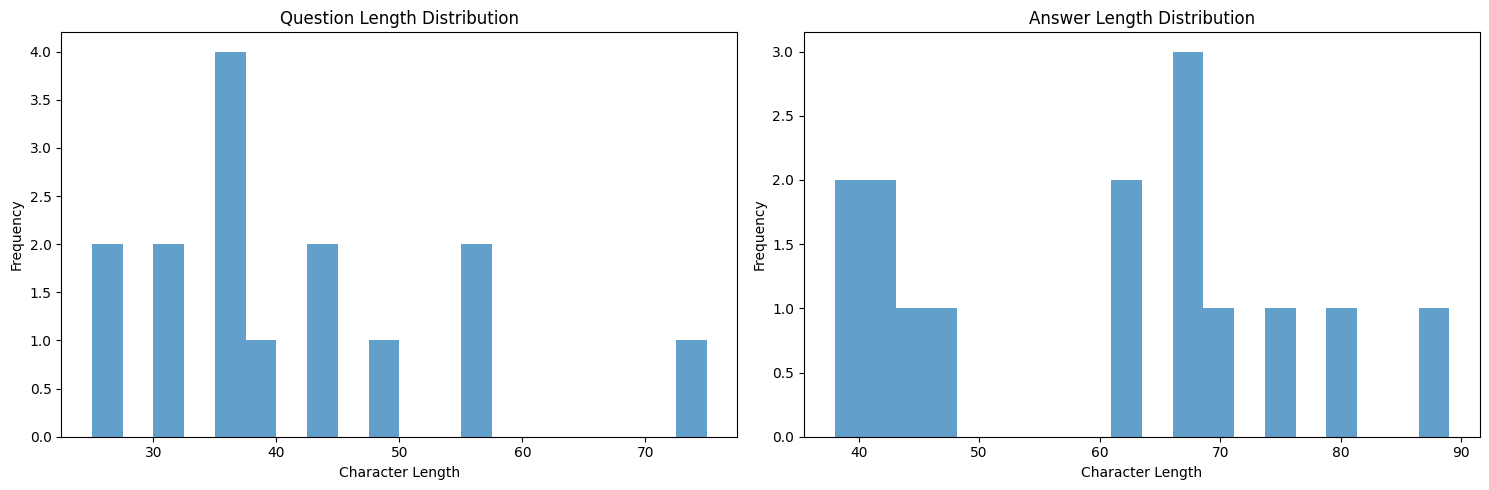

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 질문/답변 길이 분석
# q_lengths, a_lengths는 이미 정의되어 있음

# 기본 통계 계산
print(f"Average question length: {np.mean(q_lengths):.1f} chars (min: {min(q_lengths)}, max: {max(q_lengths)})")
print(f"Average answer length: {np.mean(a_lengths):.1f} chars (min: {min(a_lengths)}, max: {max(a_lengths)})")

# 시각화
plt.figure(figsize=(15, 5))

# 질문 길이 분포
plt.subplot(1, 2, 1)
plt.hist(q_lengths, bins=20, alpha=0.7)
plt.title('Question Length Distribution')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

# 답변 길이 분포
plt.subplot(1, 2, 2)
plt.hist(a_lengths, bins=20, alpha=0.7)
plt.title('Answer Length Distribution')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



### 파인튜닝 디버깅을 위한 사용자 추가 질의 반영

- 파인튜닝 데이터의 다양성과 품질을 점검하기 위해, 실제 QA 쌍 외에 테스트용 사용자 추가 질의를 데이터셋에 포함합니다.
- 추후 파인튜닝 과정에서 모델의 응답 품질을 사전에 검증하고, MLE가 처리한 데이터 전처리 및 변환 로직의 정상 동작 여부를 확인할 수 있습니다.
- 추가된 질의는 데이터셋의 마지막 부분에 삽입되어, 별도의 테스트 및 디버깅에 활용됩니다.


In [11]:
# 디버깅을 위한 추가
qa_add = [
    {
        "QUESTION": "전현상은 누구입니까?",
        "ANSWER": "전현상은 현재 Amazon Web Services의 Solutions Architect입니다.",
    },
    {
        "QUESTION": "금융보안교육센터의 주소 알려주세요.",
        "ANSWER": "금융보안교육센터의 주소는 서울특별시 영등포구 의사당대로 143 금투센터 8층 입니다.",
    },    
]
qa_pairs.extend(qa_add)

In [12]:

print(f"총 {len(qa_pairs)}개의 QA 쌍을 로드했습니다.")
print("마지막 두 개 QA 쌍:", qa_pairs[-2:])  # 새로 추가된 항목 확인

총 17개의 QA 쌍을 로드했습니다.
마지막 두 개 QA 쌍: [{'QUESTION': '전현상은 누구입니까?', 'ANSWER': '전현상은 현재 Amazon Web Services의 Solutions Architect입니다.'}, {'QUESTION': '금융보안교육센터의 주소 알려주세요.', 'ANSWER': '금융보안교육센터의 주소는 서울특별시 영등포구 의사당대로 143 금투센터 8층 입니다.'}]


## 파인튜닝을 위한 instruction 형태 변환
각 QA 쌍을 LLM 파인튜닝에 적합한 instruction 기반 포맷(`instruction`, `input`, `output` 필드)으로 변환합니다.  
변환된 데이터는 `train_data.jsonl` 파일에 한 줄씩 저장되며, 한글이 깨지지 않도록 `ensure_ascii=False` 옵션을 사용합니다.  
이 파일은 LLM 파인튜닝 학습에 사용됩니다.

In [13]:
import json

with open("data/train_data.jsonl", "w", encoding="utf-8") as f:
    for qa in qa_pairs:
        qa_modified = {
            "instruction": qa["QUESTION"],
            "input": "",
            "output": qa["ANSWER"],
        }
        f.write(json.dumps(qa_modified, ensure_ascii=False) + "\n")

In [14]:
#train_data.jsonl 의 내용 확인
with open("data/train_data.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i < 5:  # 처음 5줄만 출력
            print(line.strip())
        else:
            break
# train_data.jsonl 파일이 잘 생성되었는지 확인
import os  
if os.path.exists("data/train_data.jsonl"):
    print("train_data.jsonl 파일이 성공적으로 생성되었습니다.")
else:
    print("train_data.jsonl 파일 생성에 실패했습니다.")

{"instruction": "외환 수급 불균형 구조가 형성된 주요 원인은 무엇입니까?", "input": "", "output": "외화 유입 대비 유출 우위가 지속되어 외환 수급 불균형 구조가 형성되었습니다."}
{"instruction": "우리나라의 대외건전성이 견고해진 주요 지표는 무엇입니까?", "input": "", "output": "외환보유액이 4,000억불을 상회하고, 순대외금융자산이 1조불에 이르는 등 우리나라의 대외건전성이 견고해졌습니다."}
{"instruction": "외환 수급 균형을 위해 정부가 추진하려는 정책 방향은 무엇입니까?", "input": "", "output": "외환 수급 균형을 위해 실물경제 및 외화자금시장 안정에 도움이 되는 방향으로 외환 유입 관련 규제들을 완화하려고 합니다."}
{"instruction": "건전성 규제 완화 방안 중 선물환포지션 한도 조정 내용은 무엇입니까?", "input": "", "output": "건전성 규제 완화 방안으로 국내은행의 선물환포지션 한도를 50%에서 75%로, 외국은행 국내지점의 한도를 250%에서 375%로 상향 조정합니다."}
{"instruction": "외화조달 여건 악화로 인한 문제점은 무엇입니까?", "input": "", "output": "최근 사태로 외화조달 여건이 악화되어 건전성 규제를 맞추기 위한 분기말 외화자금수요가 확대되면서 시장 유동성에 부정적 영향을 미쳤습니다."}
train_data.jsonl 파일이 성공적으로 생성되었습니다.
